# Pixiv Image Classification (Illustation or Manga)

## Introduction

This ipynb notebook is created to document the results of my self-study in `Deep Learning`. 
The topic I will be studying is `Image Classification using the Supervised Learning` method.

The image classification system will categorize images in a simple manner by dividing them into:

- `Illustration` images: Images that do not contain any accompanying text or dialogue.
- `Manga` images: Images that do contain text or dialogue.

Examples of `Illustration` and `Manga` images.

<div style="display: flex; justify-content: center;">
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="samples\IMAGE\ILLUST Sample1.jpg" style="max-height:300px;width:auto">
      <figcaption>Illustration</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="samples\IMAGE\ILLUST Sample2.jpg" style="max-height:300px;width:auto">
      <figcaption>Illustration</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="samples\IMAGE\MANGA Sample1.jpg" style="max-height:300px;width:auto">
      <figcaption>Manga</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="samples\IMAGE\MANGA Sample2.jpg" style="max-height:300px;width:auto">
      <figcaption>Manga</figcaption>
    </figure>
  </div>
</div>

## Programing

In [1]:
import sys
sys.dont_write_bytecode = True

import os
import math
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Custom library module
import script.myFuction as myFunc

In [2]:
# Display version of TensorFlow and Python
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Display Version of Nvidia Driver and CUDA
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Fri Sep  1 16:52:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0              21W /  80W |    771MiB /  6144MiB |      6%      Default |
|                                         |     

### Configuration

In [3]:
CFG = {
    "fp16": False, # Use mixed precision training (True/False)
    "dataset_dir": ".\DATASET\ILLUST VS MANGA", # Dataset directory path
    "image_size": 128, # Image size for resizing
    "batch": 32, # Batch size
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-4), # First optimizer (lr=1e-4) for main training
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-4), # Second optimizer (lr=1e-5, decay=1e-4) for fine-tuning
    "loss_func": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

### Initializing

In [4]:
if CFG["fp16"]:
    print("Activating mixed precision float16 ... ")
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Declare functions
- `Custom_ImageDataGenerator`
- `validation_split`
- `raw_data_processing`

In [5]:
def Custom_ImageDataGenerator(image_path, label, image_size):
    # Read the image file from the given path
    image = tf.io.read_file(image_path)
    
    # Decode the image into a tensor, disabling animation expansion
    image = tf.image.decode_image(image, expand_animations=False)
    
    # Resize the image to the specified dimensions while preserving aspect ratio and using antialiasing
    image = tf.image.resize(image, (image_size, image_size),
                            preserve_aspect_ratio=True,
                            antialias=True)
    
    # Resize the image with padding to ensure it has the exact dimensions specified
    image = tf.image.resize_with_pad(image, image_size, image_size)
    
    # Normalize the image pixel values to the range [0, 1] by dividing by 255.0
    image = image / 255.0
    
    return image, label

In [6]:
def validation_split(all_list, ratio=0.1):
    # Create a list of unique class labels from the input data
    class_list = list({class_list for _, class_list in all_list})
    
    # Initialize empty lists for the training and testing data
    train = []
    test = []
    
    # Iterate through each unique class label
    for class_item in class_list:
        # Create a list of data samples with the current class label
        data_class_list = [(path, data_class) for path, data_class in all_list if data_class == class_item]
        
        # Randomly select a portion of data samples for testing based on the specified ratio
        test_class_list = random.sample(data_class_list, round(len(data_class_list) * ratio))
        
        # Remove the selected test samples from the data list to ensure they are not in the training set
        for elem in test_class_list:
            data_class_list.remove(elem)
        
        # The remaining samples in data_class_list are used for training
        train_class_list = data_class_list

        # Add the training and testing samples to the respective lists
        train += train_class_list
        test += test_class_list
    
    # Return the final training and testing data lists
    return train, test

In [7]:
def raw_data_processing(data_list, dict_class, image_size):
    # Extract the image file paths from the data_list
    path_list = [path for path, _ in data_list]
    
    # Map class labels to their corresponding dictionary values
    label_list = [dict_class[label] for _, label in data_list]
    
    # Create a list of image size values to be used as a constant size in the dataset
    size_list = [image_size] * len(label_list)
    
    # Create a TensorFlow dataset from the extracted lists
    dataset = tf.data.Dataset.from_tensor_slices((path_list, label_list, size_list))
    
    return dataset

### Dataset preparation

In [8]:
# Create a list of tuples, where each tuple contains the image path and its class label
path_list = [os.path.join(root,image) for root, _, files in os.walk(CFG["dataset_dir"], topdown=True) for image in files]
path_list = [(path, path.split('\\')[-2]) for path in path_list]
path_list[0]

('.\\DATASET\\ILLUST VS MANGA\\ILLUST\\103569114_p0,2022-12-13,SFW,Illustration,Saori,(v24794),(b8013).jpg',
 'ILLUST')

In [9]:
# Prepare class list and its corresponding dictionary for class-label mapping
class_list, dict_class = myFunc.create_dict_class(path_list)
class_list, dict_class

(['ILLUST', 'MANGA'],
 {'ILLUST': array([1., 0.], dtype=float32),
  'MANGA': array([0., 1.], dtype=float32)})

In [10]:
# Split the dataset into training and testing datasets
train_dataset, test_dataset = validation_split(path_list)
len(train_dataset), len(test_dataset)

(894, 99)

In [11]:
# Prepare the training dataset
train_dataset = raw_data_processing(train_dataset, dict_class, CFG["image_size"])
train_dataset = train_dataset.map(Custom_ImageDataGenerator)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset = train_dataset.batch(batch_size=CFG["batch"], drop_remainder = True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Prepare the testing dataset
test_dataset = raw_data_processing(test_dataset, dict_class, CFG["image_size"])
test_dataset = test_dataset.map(Custom_ImageDataGenerator)
test_dataset = test_dataset.batch(batch_size=CFG["batch"], drop_remainder = False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

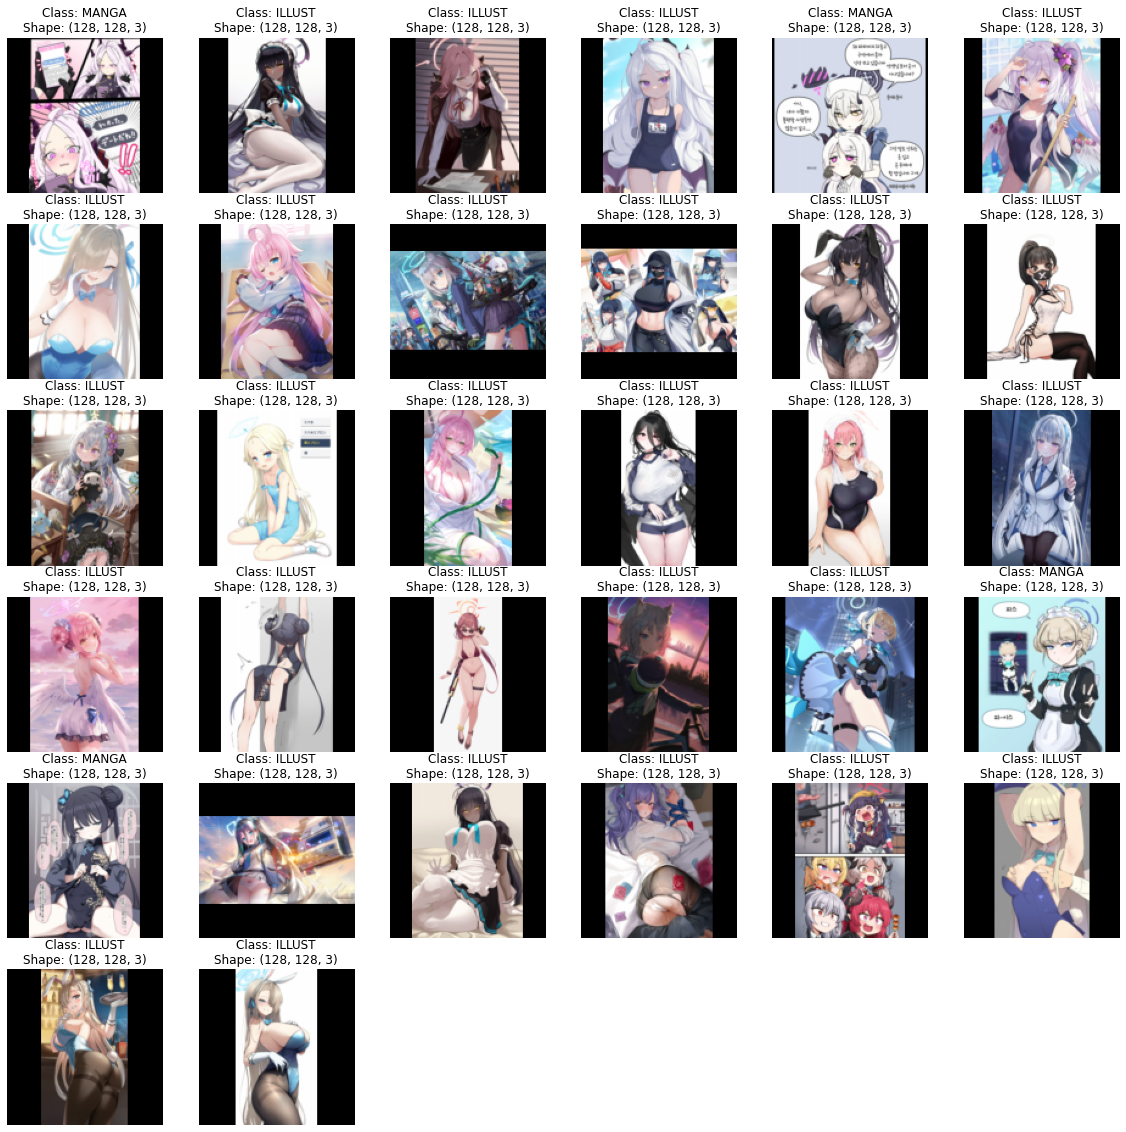

In [12]:
def view_random_batch_image(dataset, figsize=(20, 20)):
    """
    Display a random batch of images from a TensorFlow dataset.
    
    Parameters:
    - dataset: TensorFlow dataset containing image and label batches.
    - figsize: Tuple specifying the figure size for the plot.
    """
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)
    
    # Take one batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        
        # Determine the number of rows and columns for subplots based on the batch size
        base = 2
        while True:
            if math.log(len(images), base) <= 2:
                break   
            base += 1
        
        # Iterate through each image in the batch
        for i in range(len(images)):
            # Create a subplot for the current image
            plt.subplot(base, base, i + 1)
            
            # Display the image (after scaling back to uint8)
            plt.imshow((images[i] * 255).numpy().astype("uint8"))
            
            # Set the title with the class label and image shape
            plt.title(f"Class: {class_list[np.argmax(labels[i])]}\nShape: {images[i].shape}")
            
            # Turn off axis labels for cleaner visualization
            plt.axis("off")

# Note: The variable 'class_list' used in the function should be defined in the global scope.
view_random_batch_image(train_dataset)

### Model selection

In [13]:
# Uncomment to use
#from model.VGGModel import VGG11, VGG13, VGG16, VGG19
from model.ResnetModel import Resnet18, Resnet34, Resnet50, Resnet101, Resnet152
#from model.Res2NetModel import Res2Net50, Res2Net101, Res2Net152
#from model.ResNeXtModel import ResNeXt18, ResNeXt34, ResNeXt50, ResNeXt101, ResNeXt152
#from model.DenseNetModel import DenseNet121, DenseNet169, DenseNet201, DenseNet264
#from model.GooLeNetModel import Inception_v1, Inception_v1_BN
#from model.SqueezeNetModel import SqueezeNet, SqueezeNet_SimpleSkip, SqueezeNet_ComplexSkip

model = Resnet18(image_size=CFG["image_size"], num_classes=len(class_list))
model.summary()

Model: "Resnet18_128x128_2Class"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        Input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 64)   0           batch_normalization[0][0]        
____________________________________________________________________________

### Training phase1: Main training

In [14]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=10, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer1"], loss=CFG["loss_func"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
27/27 [==============================] - 10s 113ms/step - loss: 0.4089 - accuracy: 0.8252 - val_loss: 15.7231 - val_accuracy: 0.1919
Epoch 2/1000
27/27 [==============================] - 2s 78ms/step - loss: 0.1062 - accuracy: 0.9664 - val_loss: 6.6403 - val_accuracy: 0.1919
Epoch 3/1000
27/27 [==============================] - 2s 78ms/step - loss: 0.0310 - accuracy: 0.9942 - val_loss: 0.4522 - val_accuracy: 0.7879
Epoch 4/1000
27/27 [==============================] - 2s 78ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.3023 - val_accuracy: 0.8889
Epoch 5/1000
27/27 [==============================] - 2s 80ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.7990 - val_accuracy: 0.8081
Epoch 6/1000
27/27 [==============================] - 2s 80ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.6547 - val_accuracy: 0.8283
Epoch 7/1000
27/27 [==============================] - 2s 79ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9715 - val_accuracy: 0.8

### Training phase2: Fine-tuning

In [15]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     min_delta=0.01, 
                                                     patience=5, 
                                                     restore_best_weights=True, 
                                                     verbose=1)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer2"], loss=CFG["loss_func"])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train_dataset, test_dataset, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 14
Epoch 15/1000
27/27 [==============================] - 6s 110ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.6314 - val_accuracy: 0.8283
Epoch 16/1000
27/27 [==============================] - 2s 80ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.6131 - val_accuracy: 0.8283
Epoch 17/1000
27/27 [==============================] - 2s 80ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6423 - val_accuracy: 0.8182
Epoch 18/1000
27/27 [==============================] - 2s 78ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.6635 - val_accuracy: 0.8283
Epoch 19/1000
27/27 [==============================] - 2s 77ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.5489 - val_accuracy: 0.8687
Epoch 20/1000
27/27 [==============================] - 2s 78ms/step - loss: 7.5119e-04 - accuracy: 1.0000 - val_loss: 0.5832 - val_accuracy: 0.8586
Epoch 21/1000
27/27 [==============================] - 2s 79ms/step - loss: 6.0114e-04 - accuracy

### Model evaluation by plotting history

In [16]:
def plot_model_history(history):
    """
    Plot infomation about model fitting (loss and accuracy)
    """
    plt.figure(figsize=(20,6))
    
    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'], loc='lower right')
    #plt.show()

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    pass

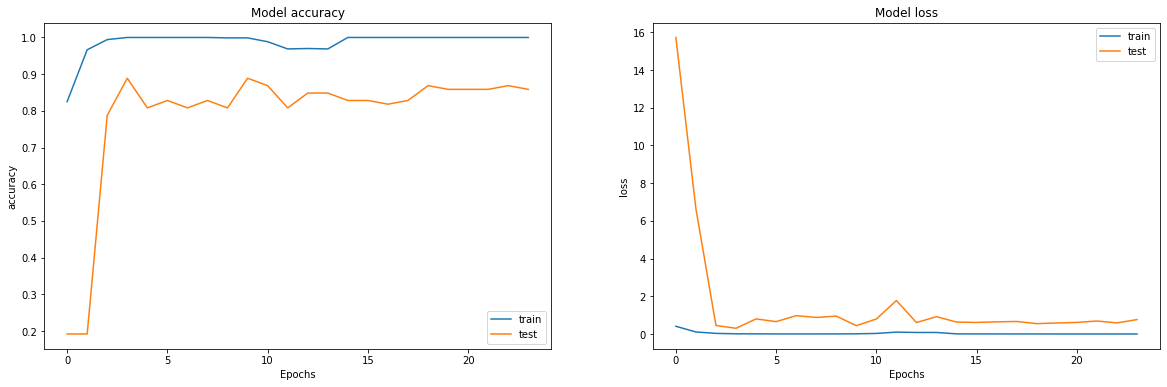

In [17]:
plot_model_history(model.history)

### Export model

In [18]:
model.save()